In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

2023-12-11 10:19:21.214215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset common operations

In [4]:
import seaborn as sn
import matplotlib.pyplot as plt

from pickle import dump,load
from os import listdir
from time import time
from scipy.stats import pearsonr

def evaluate_execution_time(file_name,function):
    if function  == "list":
        initial_time = time()
        get_dataset_itens(file_name)
        final_time =  time()
    else:
        initial_time = time()
        load_dataset_to_dataframe(file_name)
        final_time =  time() 
    return final_time - initial_time

def load_dataset_to_dataframe(file_name):
    header_length = get_header_length(file_name)
    dataset = pd.read_csv(file_name,low_memory=False)
    return dataset

def get_header(file_name):
    with open(file_name,"r") as dataset:
        header = dataset.readline().split(',')
    return header

def get_header_length(file_name):
    return len(get_header(file_name))


def get_dataset_itens(file_name):
    dataset_identifiers = []
    dataset_features = []
    dataset_labels = []
    with open(file_name,"r") as dataset:
        header = dataset.readline()
        for line in dataset:
            line_list = line.split(',')
            dataset_identifiers.append(line_list[:8])
            dataset_features.append(line_list[8:-1])
            dataset_labels.append(line_list[-1])
    return [dataset_identifiers,dataset_features,dataset_labels]


def load_all_dataset_csvs_to_dataframe(path):
    names = []
    files = listdir(path)
    for name in files:
        names.append(path+name) 
    dataset_identifiers, dataset_features, dataset_labels = load_dataset_to_dataframe(names[0])
    for file_name in names[1:]:
        new_dataset_identifiers, new_dataset_features, new_dataset_labels = load_dataset_to_dataframe(file_name)
        dataset_identifiers = pd.concat([dataset_identifiers,new_dataset_identifiers])
        dataset_features = pd.concat([dataset_features,new_dataset_features])
        dataset_labels = pd.concat([dataset_labels,new_dataset_labels])
    return dataset_identifiers,dataset_features,dataset_labels
     

def load_all_dataset_csvs_to_list(path):
    names = []
    files = listdir(path)
    dataset = [[],[],[]]
    for name in files:
        names.append(path+name)
    for file_name in names:
        data = get_dataset_itens(file_name)
        dataset = [dataset[0]+data[0],dataset[1]+data[1],dataset[2]+data[2]] 

def verify_nan_features(dfDataset):
    print('Number of missing features: ', dfDataset.isna().sum().sum(),'\n\n')
    for column_name in dfDataset.keys():
        if dfDataset[column_name].isna().sum():
            print('Number of missing features in column %s:' % str(column_name), dfDataset[column_name].isna().sum())

def binarize_label_dataframe(labels):
    return labels.apply(lambda label: 1 if (label.item() == "BENIGN") else -1, axis=1)
    
def multiclass_label_dataframe(labels):
    labels_dictionary = get_dataframe_labels_dictionary(labels)
    return labels.apply(lambda label: labels_dictionary[label.item()], axis=1)

def get_dataframe_labels_dictionary(dataframe):
    unique_labels =  list(dataframe[" Label"].unique())
    labels_dictionary = {}
    for label,name in enumerate(unique_labels):
        labels_dictionary[name] = label
    return labels_dictionary


def get_binary_labels_list(labels):
    binary_labels = []
    for item in labels:
        if item == "BENIGN\n":
            binary_labels.append(-1)
        else:
            binary_labels.append(1)
    return binary_labels

def get_labels_dictionary(labels):
    unique_labels = list(set(labels))
    labels_dictionary = {}
    for label,name in enumerate(unique_labels):
        labels_dictionary[name] = label 
    return labels_dictionary

def get_multiclass_labels(labels):
    multiclass_labels = []
    labels_dictionary = get_labels_dictionary(labels)
    for item in labels:
        multiclass_labels.append(labels_dictionary[item])
    return multiclass_labels


def write_dataset(dataset,file_name):
    with open(file_name,"wb") as dataset_file:
        dump(dataset,dataset_file)

def read_dataset(file_name):
    with open(file_name,'rb') as dataset_file:
        dataset = load(dataset_file)
    return dataset

def print_column_names(file_name):
    with open(file_name,"r") as dataset:
        names = dataset.readline()
    names_list = names.split(',')
    for item in names_list:
        print(item)


def remove_high_correlation_features(corr_matrix,features):
    high_correlation_columns = {}
    for column_name in corr_matrix.keys():
        for index in range(len(corr_matrix[column_name])):
            if (corr_matrix[column_name][index] >= 0.8) and (corr_matrix.index[index] != column_name):
                if corr_matrix.index[index] in high_correlation_columns.keys():
                    high_correlation_columns[corr_matrix.index[index]].append(str(column_name))
                else:
                    high_correlation_columns[corr_matrix.index[index]] = [str(column_name)]
    
    # separe the features 
    features_to_not_delete = []
    features_to_delete = []

    # sort features according to the number of correlated features
    for key in sorted(high_correlation_columns, key=lambda key: len(high_correlation_columns[key]), reverse=True):
        if key not in features_to_delete:
            features_to_not_delete.append(key)
            for item in high_correlation_columns[key]:
                if item not in features_to_delete:
                    features_to_delete.append(item)
    
    # delete the features
    for name in features_to_delete:
        corr_matrix.drop(name, axis='columns', inplace=True)
        corr_matrix.drop(name, axis='index', inplace=True)
        features.drop(name, axis='columns', inplace=True)



def remove_nan_features_corr(data,corr_matrix,num_features=30):
    columns_to_delete = []
    for column_name in corr_matrix.keys():
        if corr_matrix[column_name].isna().sum() == num_features:
            columns_to_delete.append(str(column_name))

    for name in columns_to_delete:
        corr_matrix.drop(name, axis='columns', inplace=True)
        corr_matrix.drop(name, axis='index', inplace=True)
        data.drop(name, axis='columns', inplace=True)
  
    return columns_to_delete

# Loading the dataset 

In [5]:
df = load_dataset_to_dataframe('../datasets/VeReMi_Extension/mixalldata_clean.csv')

In [6]:
verify_nan_features(df)
df.info

Number of missing features:  0 




<bound method DataFrame.info of          type      sendTime  sender  senderPseudo  messageID  class  \
0           4  72002.302942  130137     101301377  422013806      0   
1           4  72003.302942  130137     101301377  422023410      0   
2           4  72004.302942  130137     101301377  422032081      0   
3           4  72005.302942  130137     101301377  422040712      0   
4           4  72006.302942  130137     101301377  422052949      0   
...       ...           ...     ...           ...        ...    ...   
3194803     4  79376.752610  140895    1706441661  447808029     19   
3194804     4  79377.252610  140895    1806441661  447808677     19   
3194805     4  79377.752610  140895    1906441661  447809215     19   
3194806     4  79378.252610  140895    2006441661  447809698     19   
3194807     4  79378.752610  140895    2106441661  447810281     19   

                posx        posy  posz    posx_n  ...  aclz    aclx_n  \
0         266.982401   32.336955   0.0  3.

In [7]:
# Calculating the correlation matrix

In [8]:
corr_matrix = df.corr()

In [9]:
# Plot matrix figure

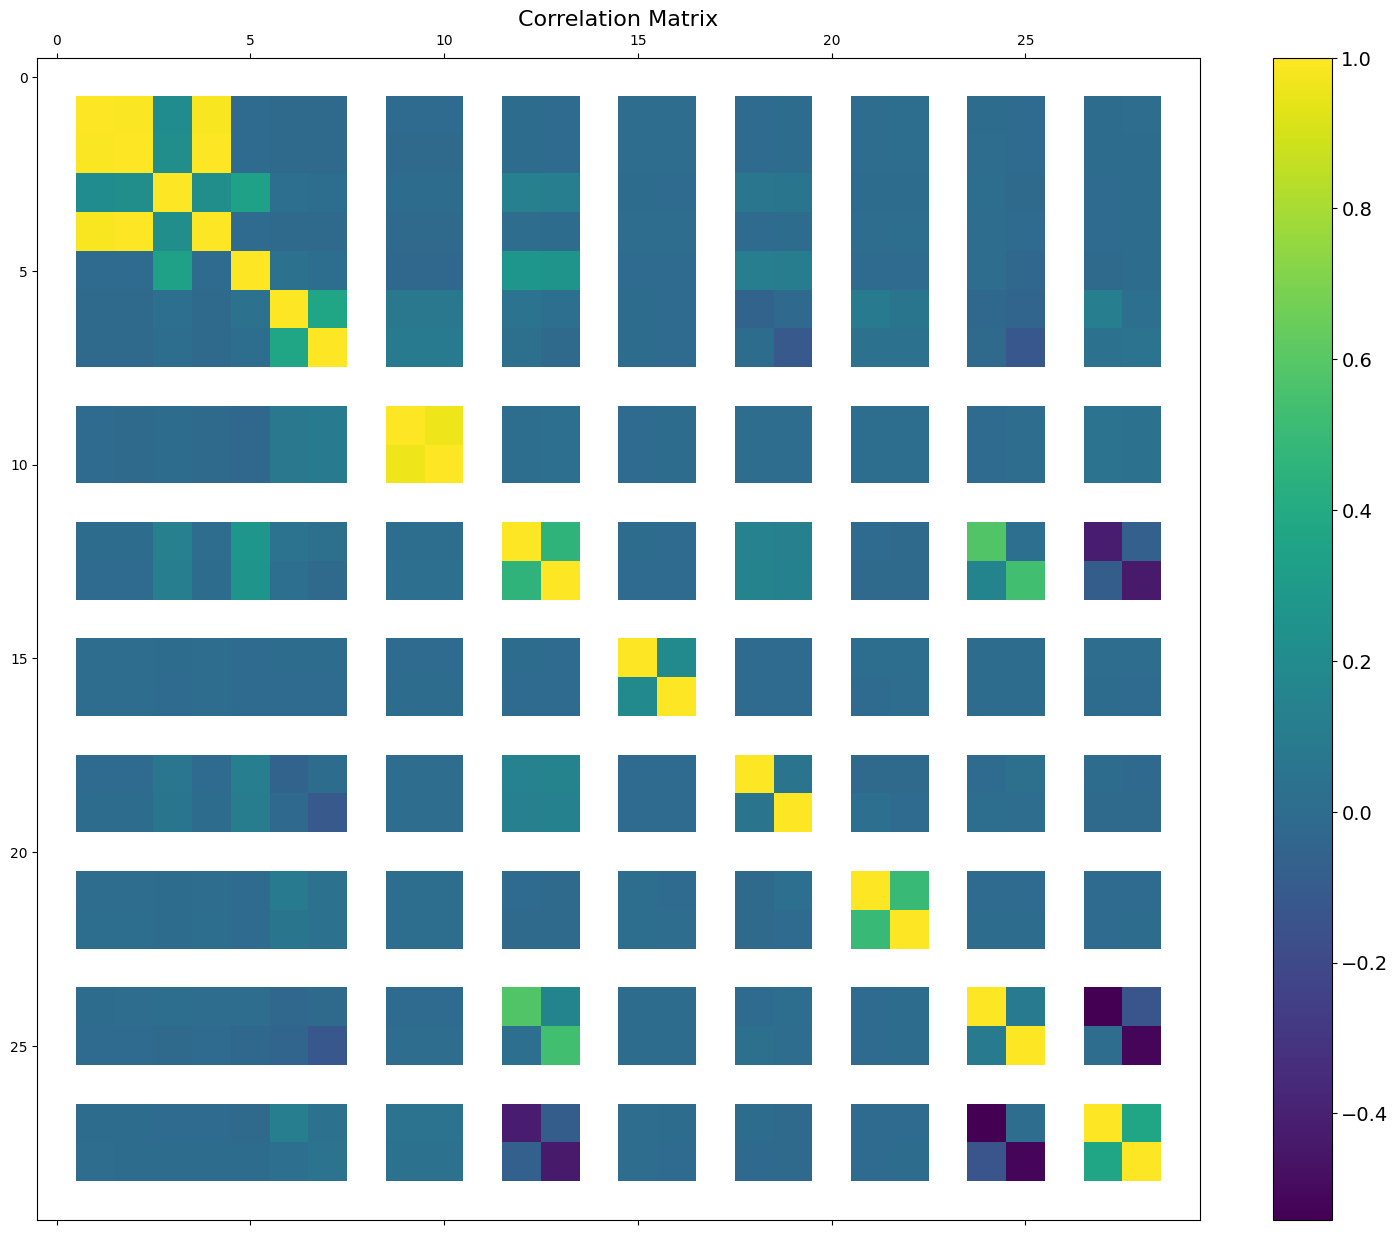

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [11]:
verify_nan_features(corr_matrix)

Number of missing features:  459 


Number of missing features in column type: 30
Number of missing features in column sendTime: 9
Number of missing features in column sender: 9
Number of missing features in column senderPseudo: 9
Number of missing features in column messageID: 9
Number of missing features in column class: 9
Number of missing features in column posx: 9
Number of missing features in column posy: 9
Number of missing features in column posz: 30
Number of missing features in column posx_n: 9
Number of missing features in column posy_n: 9
Number of missing features in column posz_n: 30
Number of missing features in column spdx: 9
Number of missing features in column spdy: 9
Number of missing features in column spdz: 30
Number of missing features in column spdx_n: 9
Number of missing features in column spdy_n: 9
Number of missing features in column spdz_n: 30
Number of missing features in column aclx: 9
Number of missing features in column acly: 9
Number of missing features 

In [12]:
print(remove_nan_features_corr(df,corr_matrix))

['type', 'posz', 'posz_n', 'spdz', 'spdz_n', 'aclz', 'aclz_n', 'hedz', 'hedz_n']


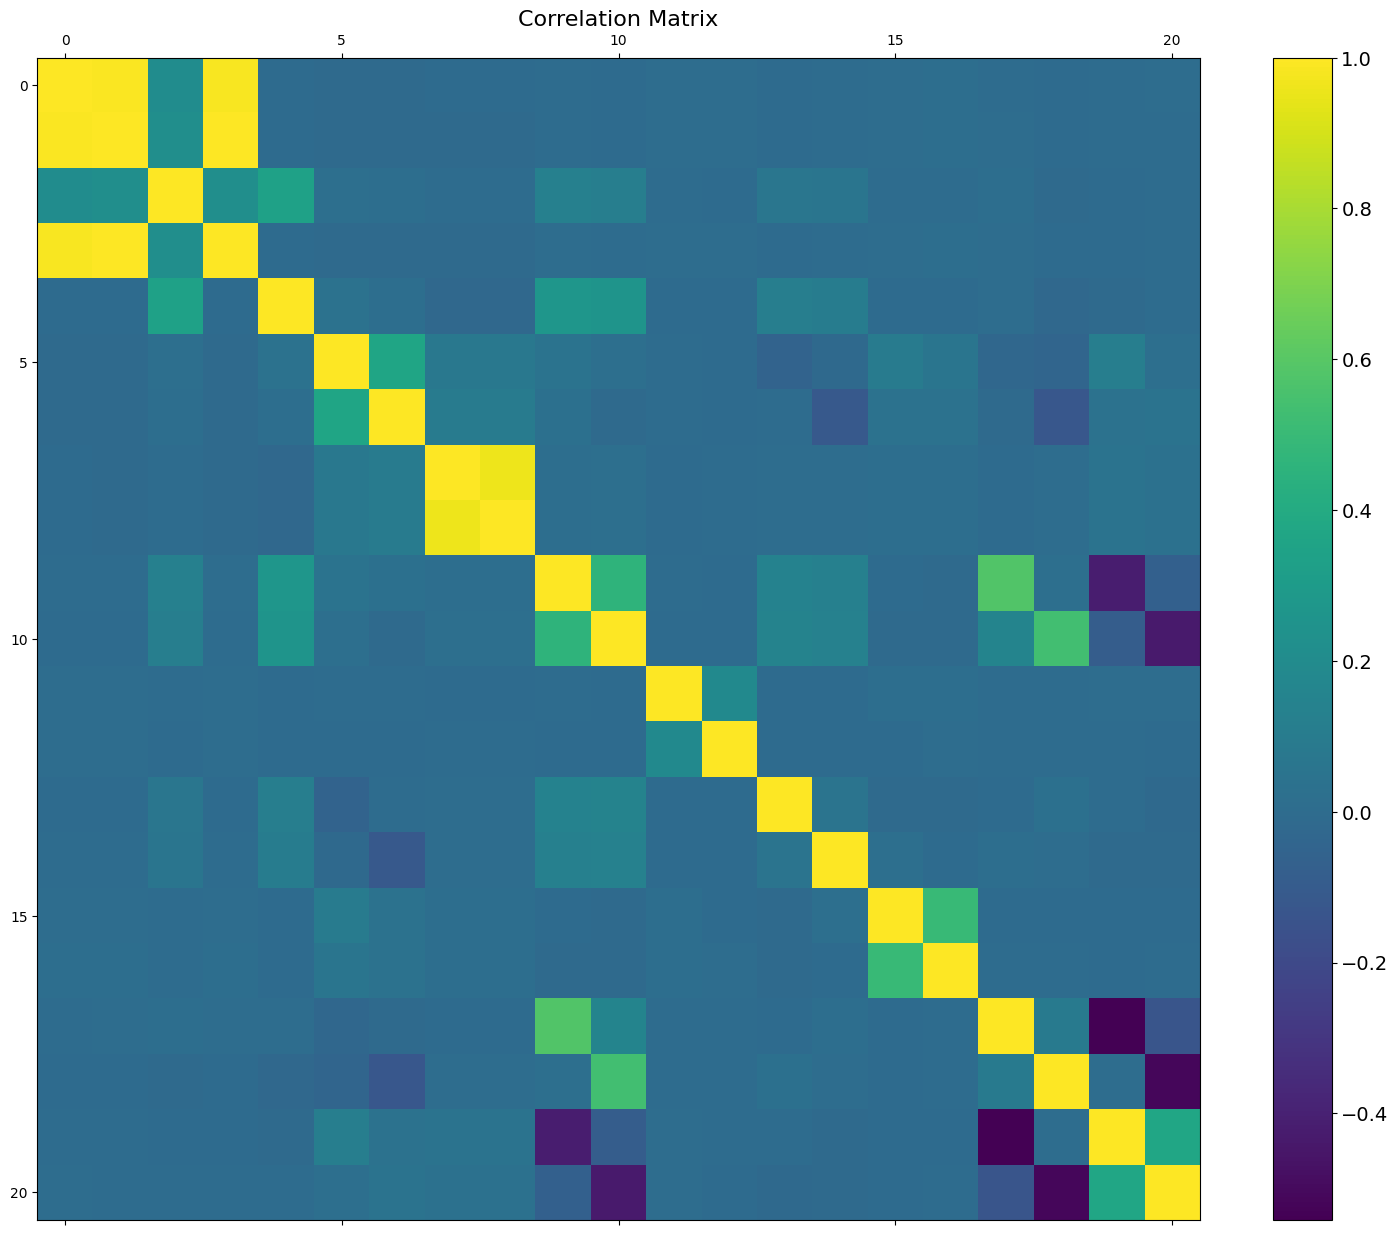

In [13]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [14]:
print(df['class'])

0           0
1           0
2           0
3           0
4           0
           ..
3194803    19
3194804    19
3194805    19
3194806    19
3194807    19
Name: class, Length: 3194808, dtype: int64


In [15]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(df.columns)-1, activation='relu', kernel_initializer='uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer='uniform'),    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu', kernel_initializer='uniform'),    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu', kernel_initializer='uniform'),    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu', kernel_initializer='uniform'),    
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer='uniform'),    
            tf.keras.layers.Dense(20, activation='softmax')])
        
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

2023-12-11 10:20:11.213705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
col = 'class'
X = df.loc[:, df.columns != col]
Y = df.loc[:, df.columns == col]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [18]:
bs = 1024

model.fit(x_train, y_train, epochs=100,batch_size=bs,steps_per_epoch=int(len(x_train)//bs))

Epoch 1/100
 457/2183 [=====>........................] - ETA: 49s - loss: 1.4946 - accuracy: 0.6518

KeyboardInterrupt: 

In [ ]:
#y_hat = model.predict(x_test)
results = model.evaluate(x_test, y_test)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



In [20]:

# Load dataset
DATA_PATH = '../datasets/VeReMi_Extension/mixalldata_clean.csv'
df = load_dataset_to_dataframe(DATA_PATH)


# Pre-process data
corr_matrix = df.corr()
remove_nan_features_corr(df,corr_matrix)

col = 'class'

X = df.loc[:,df.columns != col]
y = df.loc[:,df.columns == col]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
# Traing model
rf = RandomForestClassifier(random_state=42,n_estimators=150,
                            max_depth=None,min_samples_split=2,
                            min_samples_leaf=1)

rf = rf.fit(X_train,y_train)

# Test model
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

print('Accuracy on Test: ', accuracy)


/tmp/ipykernel_1187732/1905470555.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train,y_train)
